In [ ]:
import numpy as np
import pandas as pd
from helpers import load_csv_data,create_csv_submission
import implementation
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import torch
import torch.nn as nn

In [3]:
yb, input_data, ids = load_csv_data("./data/train.csv")

In [4]:
df_input_data = pd.DataFrame(input_data)

In [5]:
def quantile_normalize(data, q=0.95):
    low    = (1-q) / 2
    high   = 1-low
    q_low  = np.quantile(data, low,  axis=0)
    q_high = np.quantile(data, high, axis=0)
    return (data - q_low) / (q_high - q_low)

def mim_max_normalize(data):
    return (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

def z_normalize(data):
    return (data - data.mean(axis=0)) / data.std(axis=0)

In [6]:
data = np.array(df_input_data)

In [7]:
x = quantile_normalize(data, q=0.75)
y  = np.where(yb > 0, 1, 0)
tx = np.append(np.ones(len(x)).reshape(-1,1), x, axis=1)

In [18]:
x_train = torch.FloatTensor(x[:200000])
y_train = torch.FloatTensor(y[:200000].reshape(-1,1))
train_len = len(x_train)

x_test = torch.FloatTensor(x[200000:])
y_test = torch.FloatTensor(y[200000:].reshape(-1,1))
test_len = len(x_test)

In [19]:
D_in, H1, H2, D_out = 30, 20, 10, 1

def train_nn(learning_rate = 0.01, n_iter = 500):

    train_loss = np.empty(n_iter)
    test_loss = np.empty(n_iter)

    model = nn.Sequential(
        nn.Linear(D_in, H1),
        nn.Sigmoid(),
        nn.Linear(H1, H2),
        nn.Sigmoid(),
        nn.Linear(H2, D_out),
        nn.Sigmoid()
    )

    loss_fn = nn.BCELoss(reduction='sum')

    for i in range(n_iter):

        y_pred_train  = model(x_train)
        loss_train    = loss_fn(y_pred_train, y_train)
        train_loss[i] = loss_train.item()

        y_pred_test   = model(x_test)
        test_loss[i]  = loss_fn(y_pred_test, y_test).item()

        model.zero_grad()
        loss_train.backward()
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad
    return train_loss, test_loss, model

In [40]:
lr = 0.00002
best_number_iter = np.empty(n)
train_loss, test_loss, model = train_nn(learning_rate = lr, n_iter = 5000)
best_number_iter = np.argmin(test_loss)

print("Best number of iterations", best_number_iter)

Best number of iterations 4999


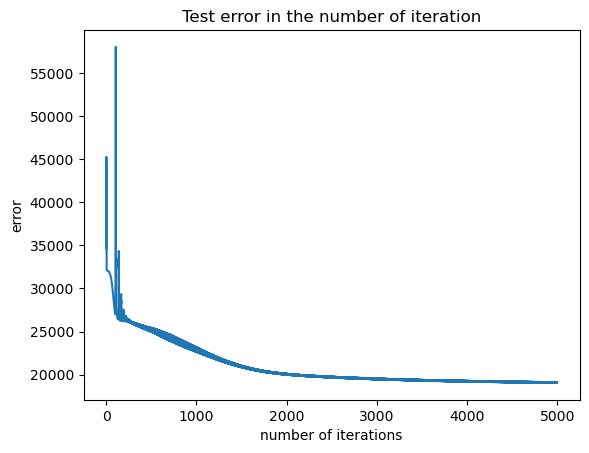

In [41]:
plt.title("Test error in the number of iteration")
plt.ylabel("error")
plt.xlabel("number of iterations")
plt.plot(test_loss);

In [42]:
best_iter = int(np.median(best_number_iter))
train_loss, test_loss, model = train_nn(learning_rate = lr, n_iter=int(best_iter))

In [43]:
y_pred_test = model(x_test)

def f(x):
    return 0 if x<0.5 else 1
y_pred_test = np.array(list(map(f, y_pred_test)))

count = 0
for i in range(len(y_test)):
    if y_pred_test[i] == y_test[i]:      
        count += 1

print("Test acuracy :",count/len(y_test))

Test acuracy : 0.82548
